# Porto Seguro by Gabriel Preda - First Try
이번 노트북은 다음의 노트북을 참고하였습니다:
* [Data Preparation and Exploration](https://www.kaggle.com/bertcarremans/data-preparation-exploration) by Bert Carremans.
* [Steering Whell of Fortune - Porto Seguro EDA](https://www.kaggle.com/headsortails/steering-wheel-of-fortune-porto-seguro-eda) by Heads or Tails
* [Interactive Porto Insights - A Plot.ly Tutorial](https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial) by Anisotropic
* [Simple Stacker](https://www.kaggle.com/yekenot/simple-stacker-lb-0-284) by Vladimir Demidov

## 1. Analysis packages

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

## 2. Load the data

In [144]:
trainset = pd.read_csv('../data/train.csv')
testset = pd.read_csv('../data/test.csv')

## 3. Few quick observations

대회(competition)의 데이터 설명을 보면 다음을 알 수 있다.
* 몇 개의 group이 정의되어 있으며 이 group에 속해있는 feature들은 **다음과 같은 특정 단어**를 포함한다.
    * `ind`: individual-driver, `reg`: region, `car`: car-itself, `calc`: calculated
* feature name 뒤에 `bin`은 **binary feature**를 말한다.
* feature name 뒤에 `cat`은 **categorical feature**를 말한다.
* `bin`이나 `cat`이 없는 feature들은 **정수(ordinal value)의 실수값(continuous value)**을 가진다.
* missing value는 **-1**로 표현된다.
* 예측하려는 feature는 **target** feature이며 *보험청구 여부*를 나타낸다.
* id는 데이터 입력 순서를 말한다.

In [145]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


0에서 어떤 정수 n까지의 범위를 갖는 `cat` value들은 **categorical feature**임을, 0이나 1의 value를 갖는 feature는 **binary feature**을 볼 수 있다.

In [146]:
print('Train dataset (rows, cols) :', trainset.shape, '\nTest dataset (rows, cols) :', testset.shape)

Train dataset (rows, cols) : (595212, 59) 
Test dataset (rows, cols) : (892816, 58)


train 데이터셋은 **59개의 feature**가, test 데이터셋에는 **58개의 feature**가 있음을 볼 수 있다. 한 개가 부족한 것은 test 데이터셋에 `target` feature가 없기 때문이다.

In [147]:
print('Columns in train and not in test dataset :', set(trainset.columns) - set(testset.columns))

Columns in train and not in test dataset : {'target'}


## 4. Introduction of metadata
데이터를 더 쉽게 조작(manipulate)하기 위해서 trainset의 variable에 몇 개의 meta 정보를 만들어보자.
* **use** : input, ID, target
* **type** : nominal, interval, ordinal, binary
* **preserve** : True, False
* **dataType** : int, float, char
* **category** : ind, reg, car, calc

In [148]:
# reference : https://www.kaggle.com/bertcarremans/data-preparation-exploration
data = []
for feature in trainset.columns:
    # role 정의
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
    
    # type 정의
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == np.float64 or isinstance(trainset[feature].dtype, float):
        type = 'real'
    elif trainset[feature].dtype == np.int64 or isinstance(trainset[feature].dtype, int):
        type = 'integer'
    
    # id를 제외하고 preserve를 True로 설정
    preserve = True
    if feature == 'id':
        preserve = False
    
    # datatype 정의
    dtype = trainset[feature].dtype
    
    # category 정의
    category = 'none'
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    # variable의 metadata를 정의한 dict
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category': category
    }
    data.append(feature_dictionary)

In [149]:
metadata = pd.DataFrame(
    data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


`indexing`과 `index`를 사용하여 다음과 같이 categorical feature를 추출할 수 있다.

In [150]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

각 `category`별 feature의 개수는 다음과 같다.    
→ *calcaluted*는 20개, *car*는 16개, *individual*은 18개, *none*은 2개, *registration*은 3개

In [151]:
pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


이번에는 `type`과 `use`에 따라 feature 개수를 센 것이다.
* *nominal feature* : 1개 (=id)
* *binary feature* : 20개
* *real-number feature* : 21개
* *categorical feature* : 16개
* *target feature* : 1개

In [152]:
pd.DataFrame({'count': metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


## 5. Data analysis and statistics
### 5.1. Target variable
`target==1`인 데이터의 비율은 **3.64%**이다. 이를 보아 trainset이 극단적으로 불균형적(imbalanced)함을 알 수 있다.     
이를 해결하기 위해 다음과 같은 방법을 사용한다.
* **방법1.** `target==0`을 undersampling 
* **방법2.** `target==1`을 oversampling 

trainset의 크기가 크므로 `target==0`을 undersampling할 것이다.

<Figure size 432x288 with 0 Axes>

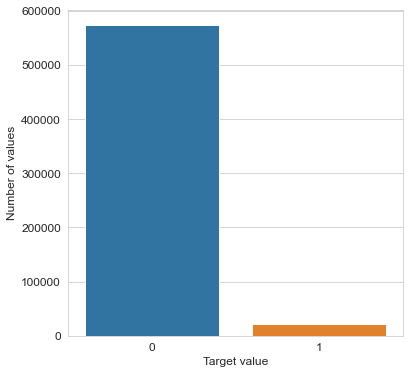

In [153]:
# target value별 데이터 개수
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

# target value의 count를 기준으로 역 정렬 - barplot
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

### 5.2. Real features

**features with missing values**     
`ps_reg_03`, `ps_car_12`, `ps_car_14`의 최소값이 -1인 것으로 보아 missing value를 가지고 있음.

**registration features**    
`ps_reg_01`와 `ps_reg_02`는 0.1, 0.2와 같은 분모가 10인 분수임.

In [154]:
# real feature
variables = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variables].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


**car features**    
`ps_car_12`을 근사적으로 (10이 곱하져) 자연수의 제곱근이고, `ps_car_15` 또한 자연수의 제곱근이다.

In [155]:
(pow(trainset['ps_car_12'], 2)).head(10)

0    0.1600
1    0.1000
2    0.1000
3    0.1400
4    0.0999
5    0.1989
6    0.1000
7    0.1998
8    0.1600
9    0.2000
Name: ps_car_12, dtype: float64

In [156]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

> **seaborn.pairplot(data, hue=None, palette=None, diag_kind='auto')**    
> 데이터프레임을 인수로 받아 그리드(grid) 형태로 각 데이터 열의 조합에 대해 스캐터 플롯을 그린다. 같은 데이터가 만나는 대각선 영역에는 해당 데이터의 히스토그램을 그린다.
> * `data` : DataFrame
> * `hue` : 각 값에 따라 다른 색으로 표현하기 위한 feature
> * `palette` : hue의 색을 mapping하기 위한 색상들 
> * `diag_kind` : 대각선의 plot 지정 

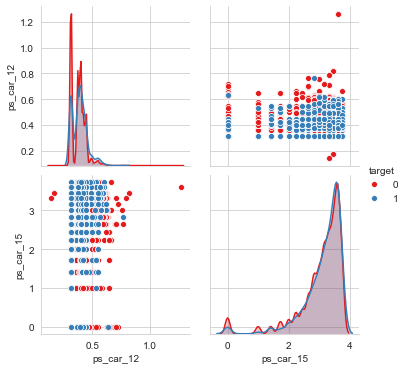

In [157]:
sample = trainset.sample(frac=0.05)    # 일부만 추출
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]

# ps_car_12와 ps_car_15의 값에 따른 target의 값
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

**calculated features**    
최대값이 모두 0.9인 것을 보아 `ps_calc_01`, `ps_calc_02`, `ps_calc_03`는 매우 비슷한 분포(distribution)을 갖고 있다고 볼 수 있다. 다른 calculated features의 값들은 최대값으로 5, 6, 7, 10, 12을 가진다.

<Figure size 432x288 with 0 Axes>

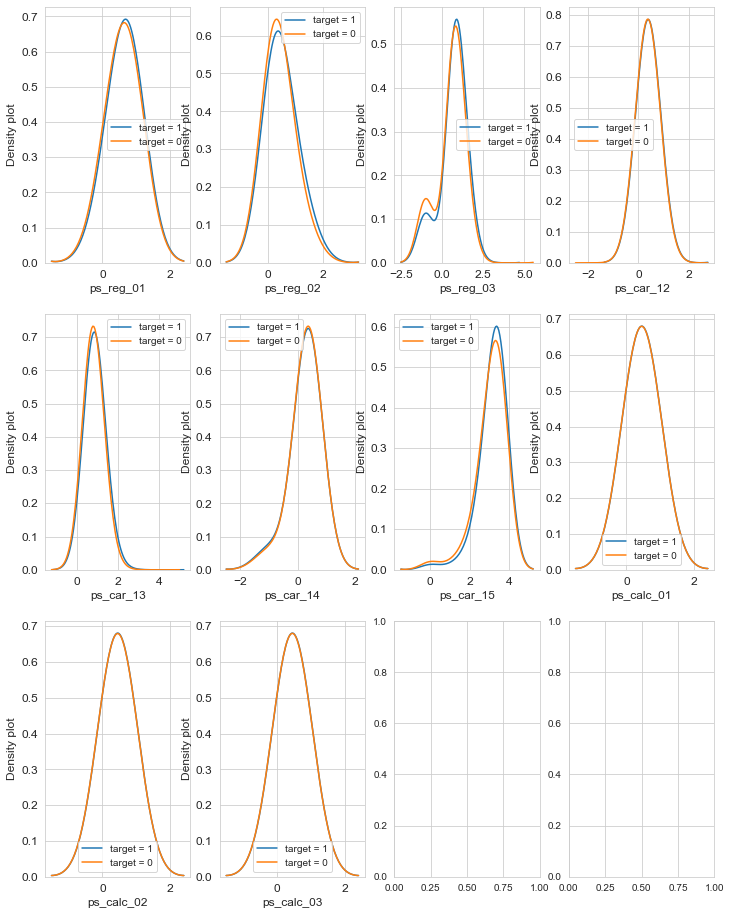

In [158]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

# 각 feature별 target value의 분포
for feature in var:
    i += 1
    plt.subplot(3, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

`ps_reg_02`, `ps_car_13`, `ps_car_15`는 `target=0`과 `target=1`일 때의 분포가 많이 다른 것을 볼 수 있다.

이번에는 real feature간의 상관관계를 보자.

In [159]:
def corr_heatmap(var):
    correlations = trainset[var].corr()

    # 두 color 사이의 colormap 생성
    cmap = sns.diverging_palette(50, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={'shrink': .75})
    plt.show()

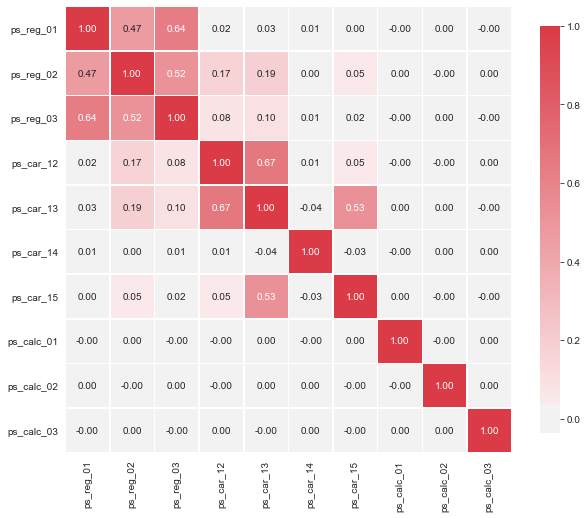

In [160]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

calculated features 중 다음의 두 feature들은 **강한 상관관계**를 가진다.
* `ps_reg_01`과 `ps_reg_02` : 0.47
* `ps_reg_01`과 `ps_reg_03` : 0.64
* `ps_reg_02`와 `ps_reg_03` : 0.52
* `ps_car_12`와 `ps_car_13` : 0.67
* `ps_car_13`와 `ps_car_15` : 0.53

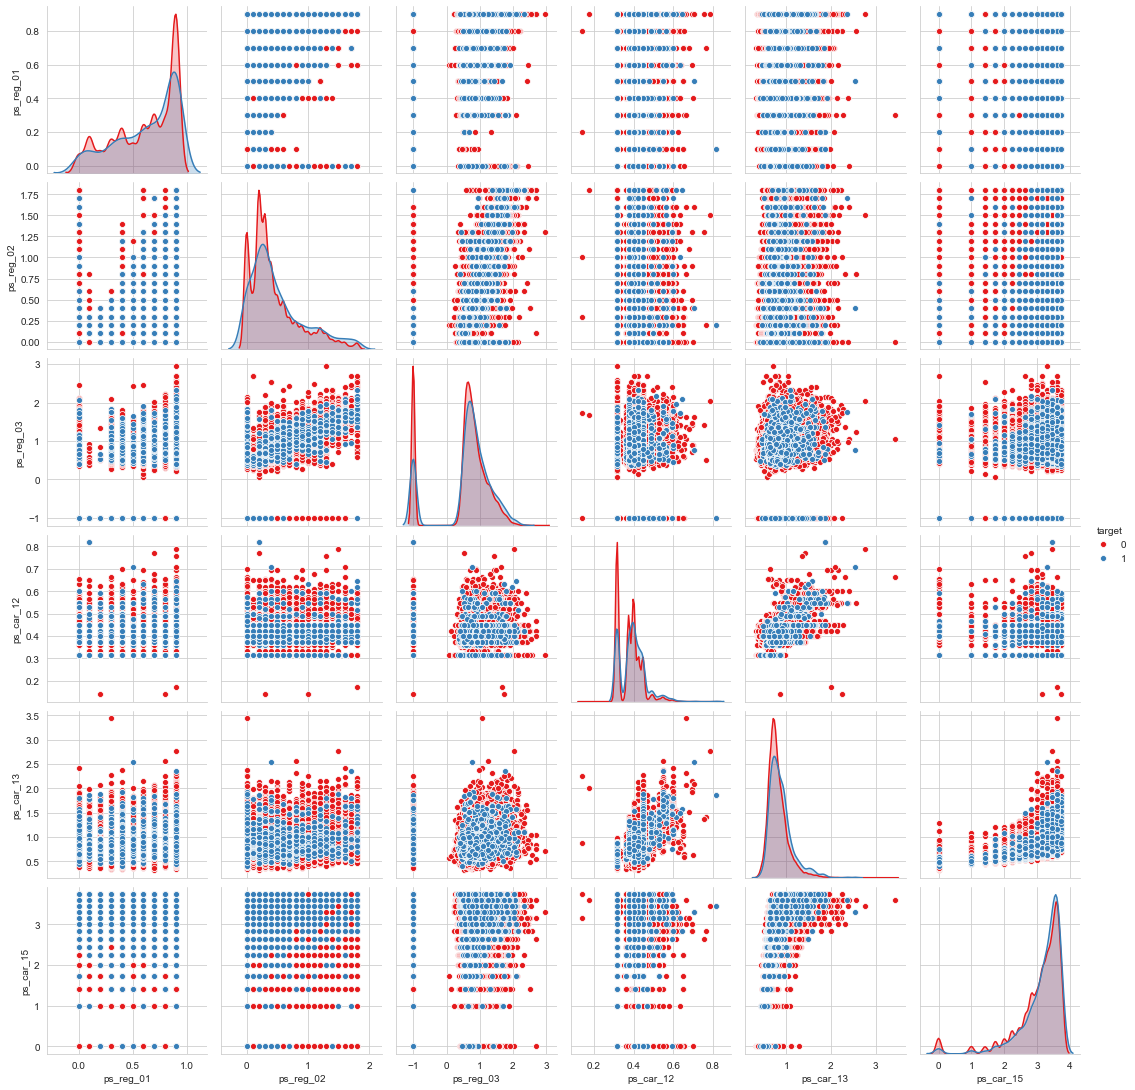

In [161]:
sample = trainset.sample(frac=0.05)    # 일부만 추출
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']    
sample = sample[var]

# 상관관계가 높은 feature들의 관계 - pairplot
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

### 5.3. Binary features

In [163]:
# binary feature
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[var].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


trainst의 binary feature들의 value의 분포를 살펴보자. `0`을 빨간색🔴으로 `1`을 파란색🔵으로 나타내었다.

<Figure size 432x288 with 0 Axes>

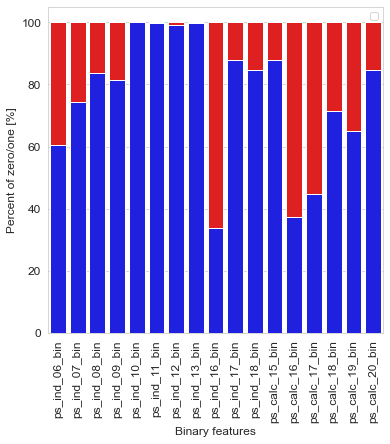

In [165]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []   # 0일 때의 비율
one_list = []    # 1일 때의 비율

for col in bin_col:
    zero_list.append((trainset[col] == 0).sum()/trainset.shape[0]*100)
    one_list.append((trainset[col] == 1).sum()/trainset.shape[0]*100)

plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))

# binary feature별 0과 1의 비율 - barplot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color='blue')
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom=zero_list, color='red')

plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('zero', 'one'))
plt.show()

`ps_ind_10_bin`, `ps_ind_11_bin`, `ps_ind_12_bin`, `ps_ind_13_bin`은 0.5%도 안 되는 **1**의 비율을 갖고 있다. 반면 `ps_ind_16_bin`과 `ps_cals_16_bin`은 60%가 넘는 **1**의 비율을 가진다.

이번에는 **target value에 따른 binary feature의 분포**를 살펴보자.

<Figure size 432x288 with 0 Axes>

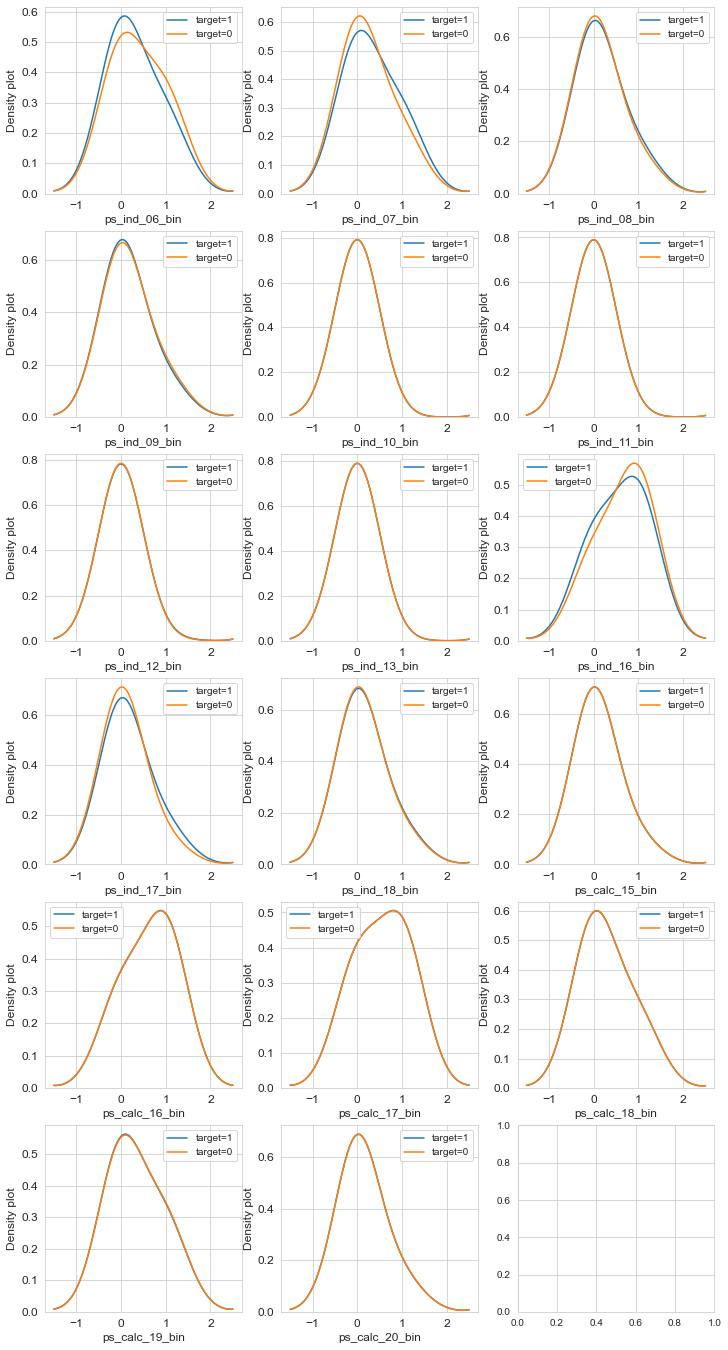

In [166]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6, 3, figsize=(12, 24))

# target에 따른 binary feature의 분포 - kdeplot
i = 0
for feature in var:
    i += 1
    plt.subplot(6, 3, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target=1')
    sns.kdeplot(t0[feature], bw=0.5, label='target=0')
    
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

`ps_ind_06_bin`, `ps_ind_07_bin`, `ps_ind_16_bin`, `ps_ind_17_bin`는 **0**과 **1**일 때의 분포가 불균형(inbalance)적인 것을 볼 수 있다. (차이가 많이 난다는 뜻인 듯)     
반면 `ps_ind_08_bin`은 매우 비슷한 밀도를 가진 다른 feature에 비해 작은 불균형을 보여준다.

### 5.4. Categorical features
categorical feature의 분포를 두 가지 방식으로 나타내보다.

첫 번째 방법은 각 카테고리 value 별 `target=1`의 비율을 계산하고 이를 barplot으로 표현한다.

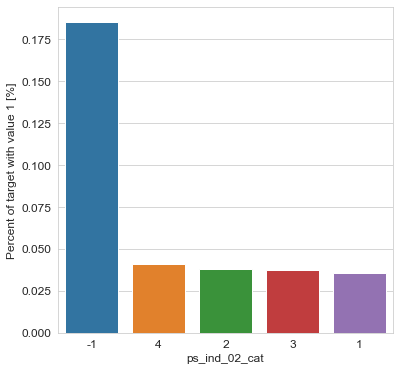

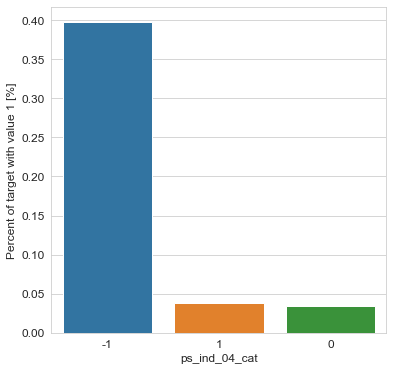

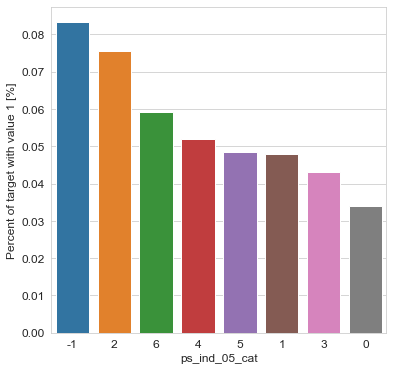

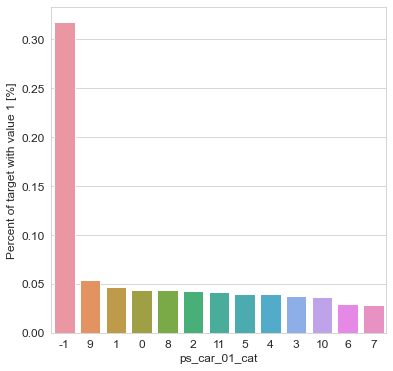

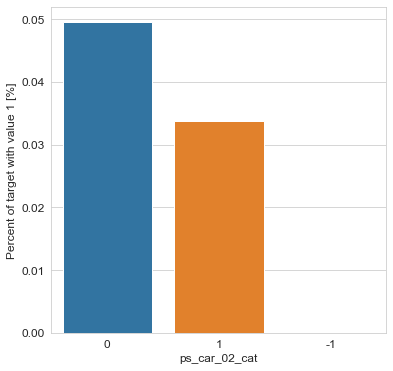

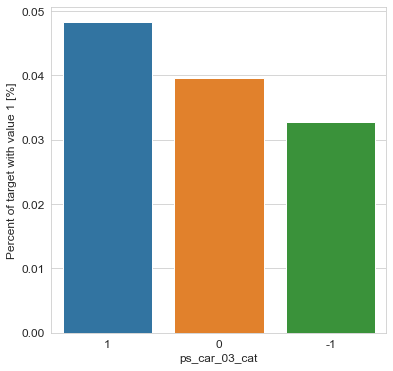

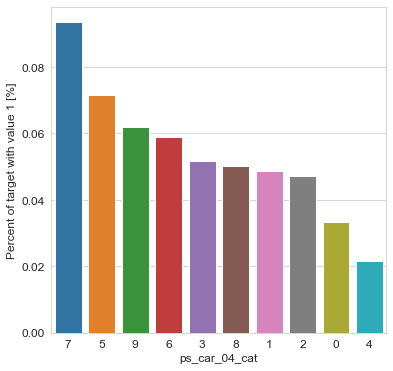

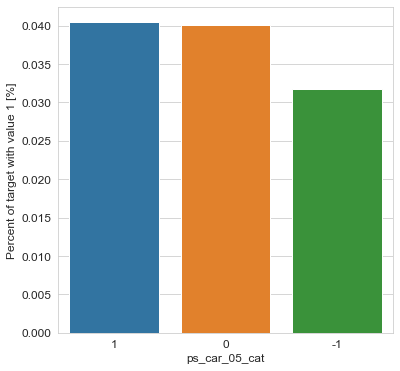

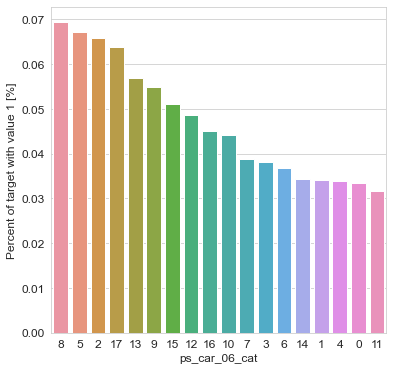

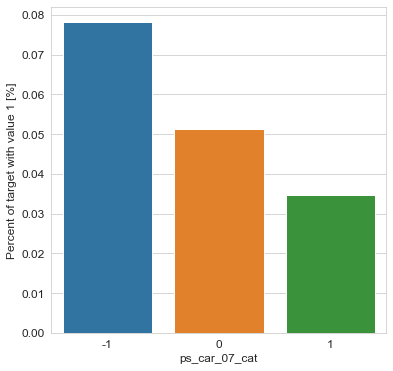

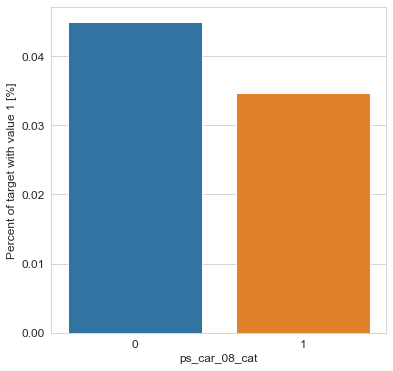

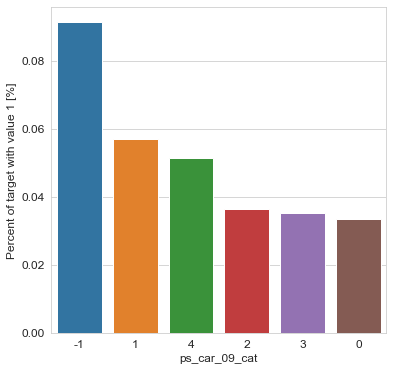

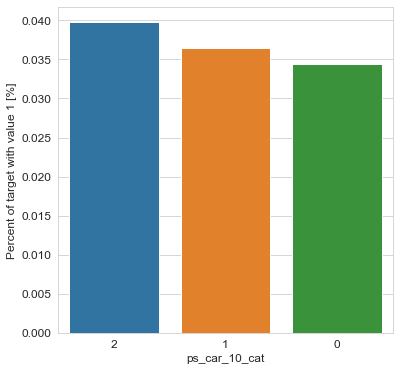

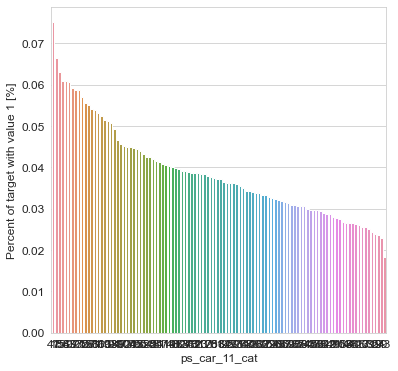

In [168]:
# categorical feature 분포 표현 방법 1. barplot
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # category value별 target=1의 비율
    cat_perc = trainset[[feature, 'target']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    # target의 평균값을 기준으로 역 정렬 - barplot
    sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

두 번째 방법은 categorical feature를 **density plot**을 사용하여 나타내는 것이다. `target=0`과 `target=1`인 데이터를 각각 추출해 2개 모두 density plot으로 나타내는 것이다.

<Figure size 432x288 with 0 Axes>

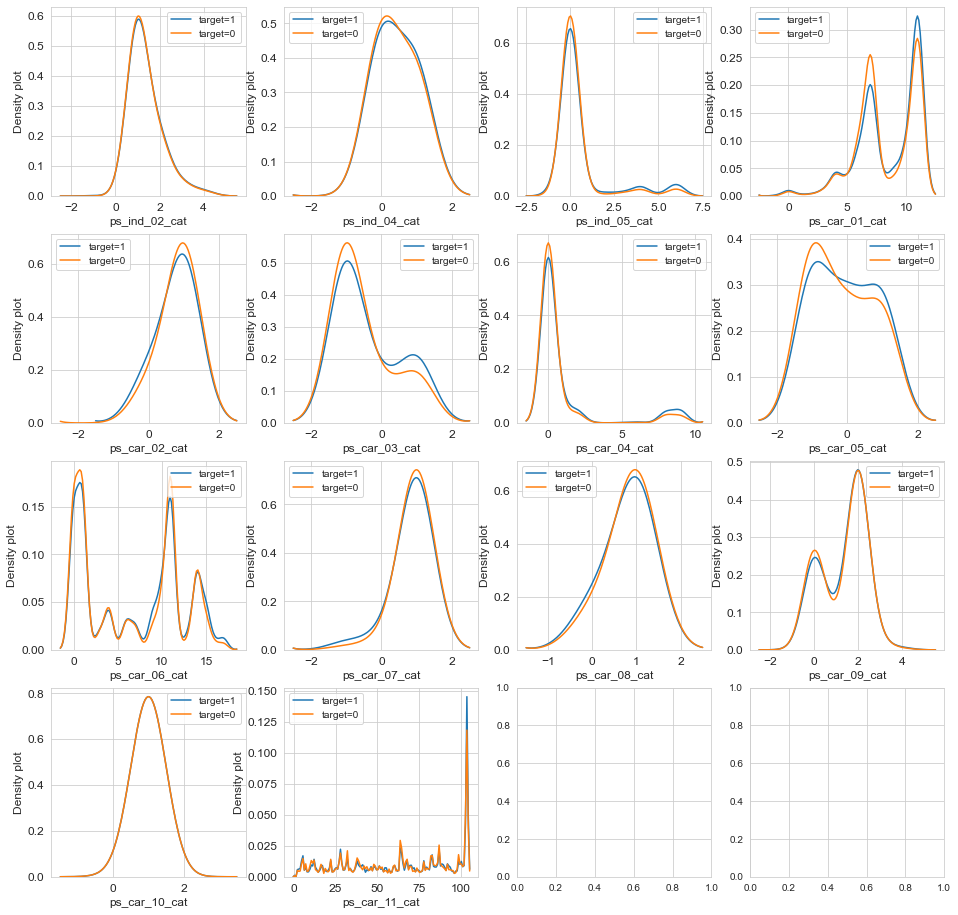

In [169]:
# categorical feature 분포 표현 방법 2. density plot
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

i = 0
for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target=1')
    sns.kdeplot(t0[feature], bw=0.5, label='target=0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    
plt.show()

`ps_car_03_cat`, `ps_car_05_cat`은 **target=0**과 **target=1**에 따른 value의 density 차이가 가장 큰 것을 볼 수 있다.

## 6. Data unbalance between train and test data
먼저 trainset과 testset의 feature들의 분포를 살펴보자.

### 6.1. registration features

<Figure size 432x288 with 0 Axes>

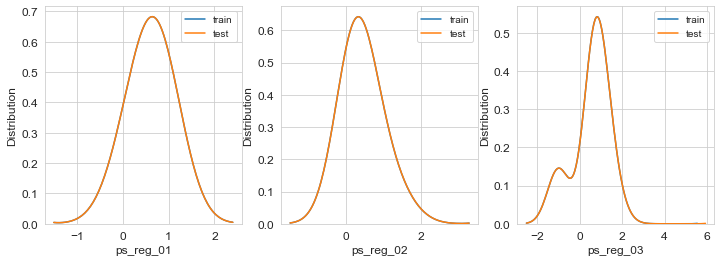

In [170]:
# registration feature의 train과 testset 분포
var = metadata[(metadata.category == 'registration')
               & (metadata.preserve)].index

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i = 0
for feature in var:
    i += 1
    plt.subplot(1, 3, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

`reg` feature는 trainset과 testset의 균형(balance)를 잘 보여준다.

### 6.2. car features

<Figure size 432x288 with 0 Axes>

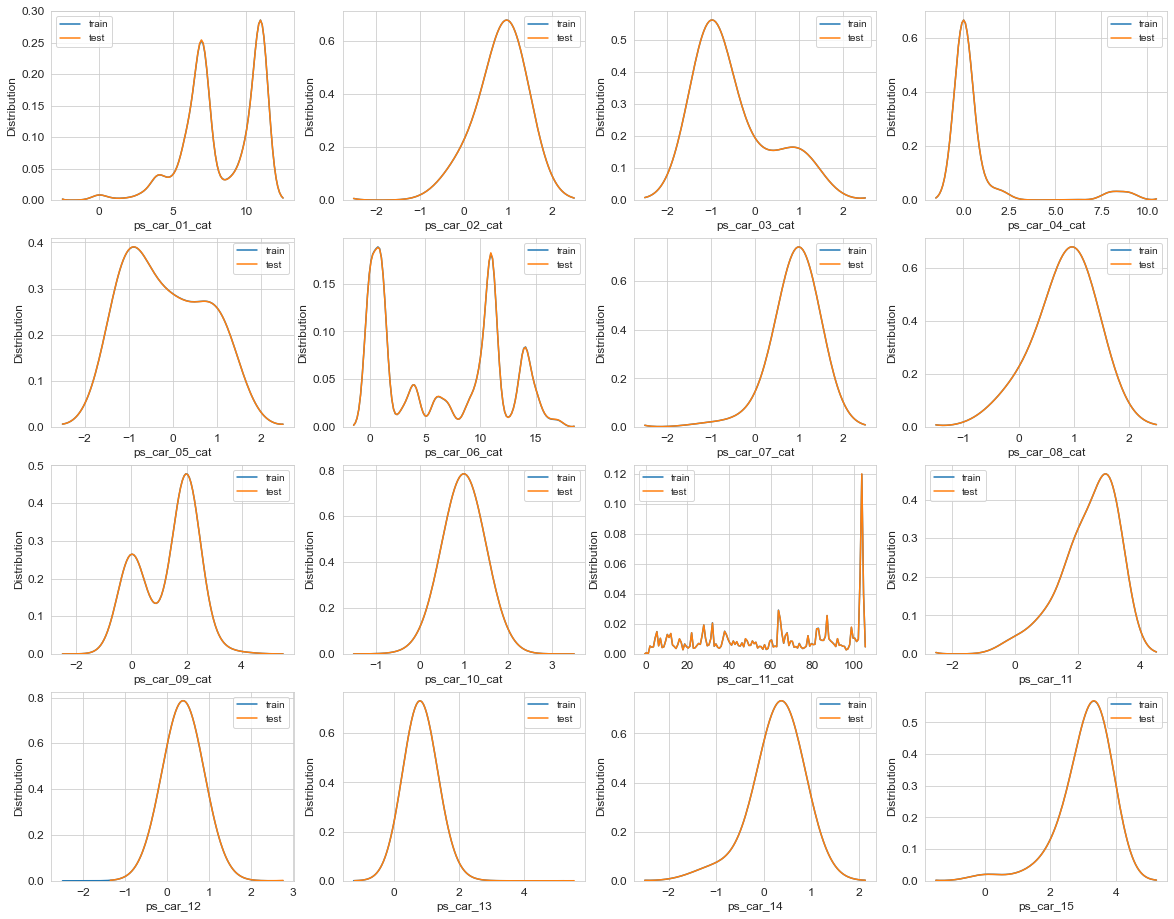

In [171]:
# car feature의 train과 testset 분포
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

`car` feature 또한 모든 feature가 trainset과 testset에서 균형적인(balanced) 것을 보여준다.

### 6.3. individual feature

<Figure size 432x288 with 0 Axes>

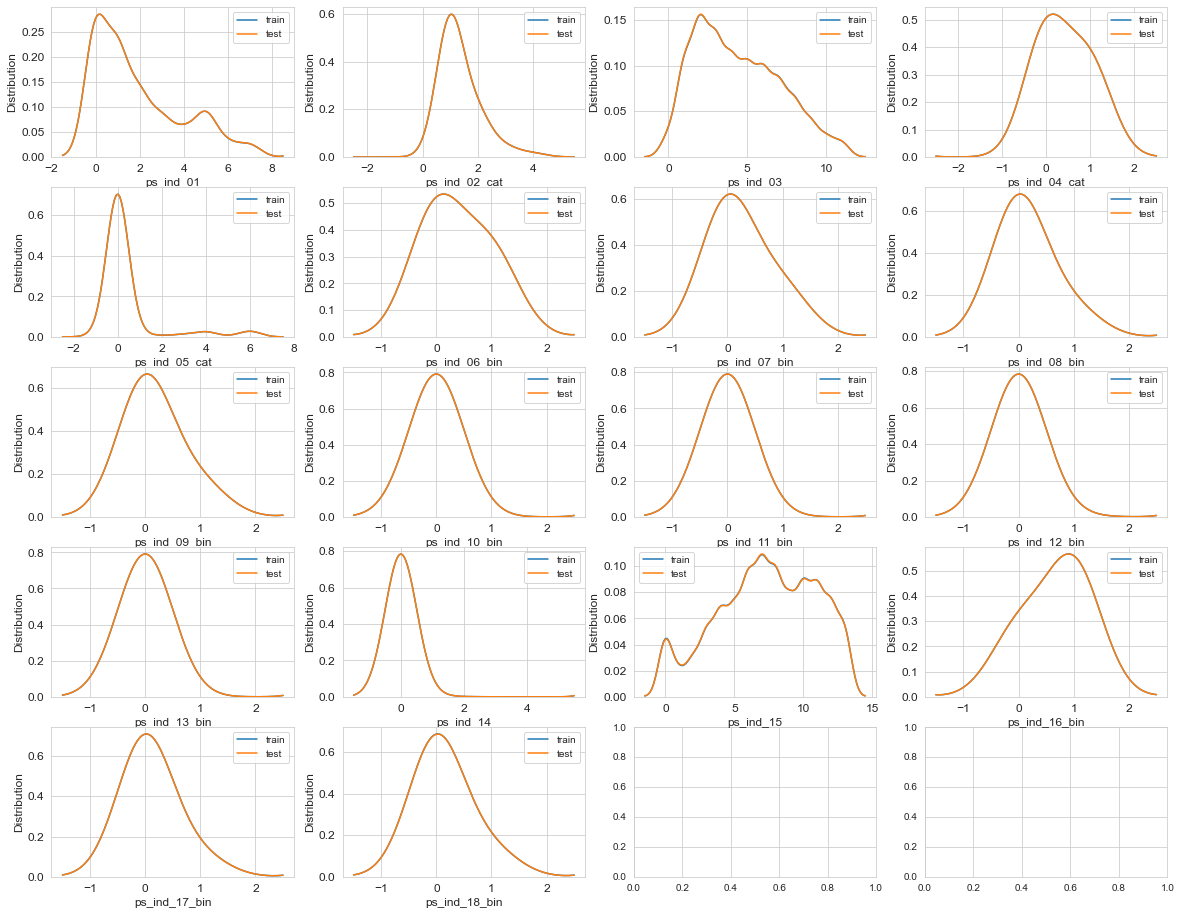

In [172]:
# individual feature의 train과 testset 분포
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

`individual` feature도 모든 feature가 trainset과 testset에서 균형적인(balanced) 것을 보여준다.

### 6.4. calc features

<Figure size 432x288 with 0 Axes>

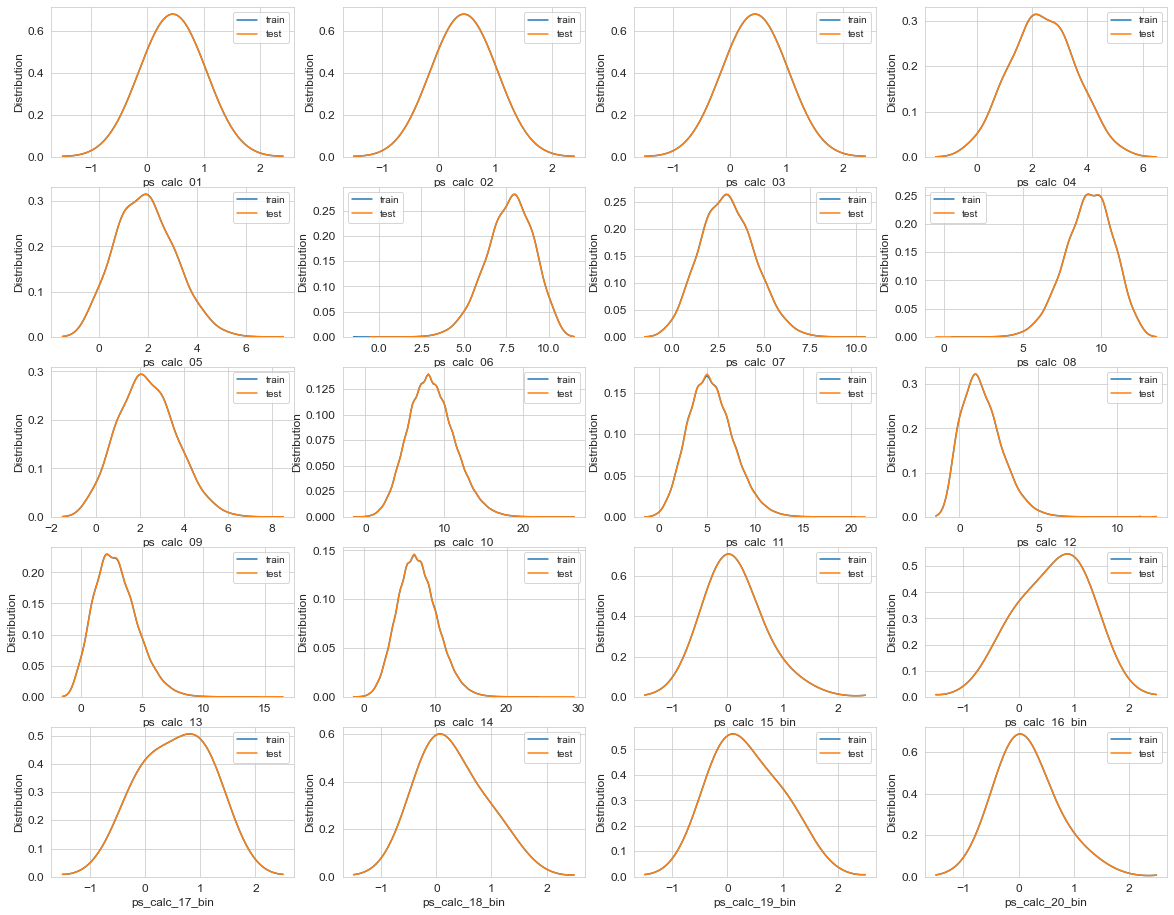

In [173]:
# calc feature의 train과 testset 분포
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

`calc` feature도 trainset과 testset 모두 균형적임을 볼 수 있다.

[Dmitry Altukhov, Kaggle Porto Seguro's Safe Driver Prediction](https://www.youtube.com/watch?v=mbxZ_zqHV9c)에서`calc` feature의 경우 모두 feature engineering이 되어 있고 실제로는 아에 관계가 없는 feature일 수도 있다고 한다. (왜인지는 모름) 그렇기 때문에 한 개 이상의 예측 모델을 사용한 `CV` score를 사용하여 조심스럽게 제거해나가야 한다. (그렇다고 함부로 지우면 안된다는 뜻?인가)

## 7. Check data quality
각 feature의 missing value를 살펴보자.

In [174]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[trainset[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings / trainset.shape[0]

        print('Variable {} has {} records ({:.2%}) with missing values.'.format(
            feature, missings, missings_perc))

print('In total, there are {} variables with missing values.'.format(
    len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values.
Variable ps_ind_04_cat has 83 records (0.01%) with missing values.
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values.
Variable ps_reg_03 has 107772 records (18.11%) with missing values.
Variable ps_car_01_cat has 107 records (0.02%) with missing values.
Variable ps_car_02_cat has 5 records (0.00%) with missing values.
Variable ps_car_03_cat has 411231 records (69.09%) with missing values.
Variable ps_car_05_cat has 266551 records (44.78%) with missing values.
Variable ps_car_07_cat has 11489 records (1.93%) with missing values.
Variable ps_car_09_cat has 569 records (0.10%) with missing values.
Variable ps_car_11 has 5 records (0.00%) with missing values.
Variable ps_car_12 has 1 records (0.00%) with missing values.
Variable ps_car_14 has 42620 records (7.16%) with missing values.
In total, there are 13 variables with missing values.


## 8. Prepare the data for model
### 8.1. Drop calc columns
[Dmitry Altukhov, Kaggle Porto Seguro's Safe Driver Prediction](https://www.youtube.com/watch?v=mbxZ_zqHV9c)에서 조언한 것처럼 `calc` feature를 제거한다. 앞서 말한 것처럼 Dmitry Altukhov에 따르면 `calc` feature를 연속적으로 지움으로써 CV score를 개선시킬 수 있다고 한다. (그냥 지우는 거 말고 좀 더 잘 지워서 성능을 높이는 방법인듯?)

In [176]:
# 관계 없는 calc feature 제거
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)
testset = testset.drop(col_to_drop, axis=1)

### 8.2. Drop variables with too many missing values
missing value를 많이 가진 `ps_car_03_cat`과 `ps_car_05_cat`를 제거한다.

In [177]:
# missing value가 많은 feature 제거
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop), 'keep'] = False  # metadata 업데이트

### 8.3. Replace ps_car_11_cat with encoded value
`target_encode`함수를 사용하여 trainset과 testset의 `ps_car_11_cat`을 encoding한다.

In [178]:
# reference : https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """
    # 최소 실행 조건 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    
    # target 평균값 계산
    averages = temp.groupby(by=trn_series.name)[
        target.name].agg(["mean", "count"])
    
    # smoothing 계산
    smoothing = 1 / \
        (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # target data의 평균을 계산
    prior = target.mean()
    
    # 개수가 많을 수록 full_avg가 덜 고려됨
    averages[target.name] = prior * \
        (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # averages를 trn_series와 tst_series에 적용
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(
            columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(
            columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge는 인덱스를 갖지 않으므로 복구
    ft_trn_series.index = trn_series.index
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [179]:
train_encoded, test_encoded = target_encode(trainset["ps_car_11_cat"],
                                            testset["ps_car_11_cat"],
                                            target=trainset.target,
                                            min_samples_leaf=100,
                                            smoothing=10,
                                            noise_level=0.01)

trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat', 'keep'] = False  # metadata 업데이트
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

### 8.4. Balance target variable
target variable이 매우 불균형(unbalanced)적임을 볼 수 있다. 이는 `target=0`을 undersampling하거나 `target=1`을 oversampling하는 방법으로 해결할 수 있다.

현재 데이터셋의 크기가 크므로 **undersampling**을 적용해보자.

In [181]:
desired_apriori = 0.10

# target value별 index
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# target value별 데이터 개수
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# undersampling rate 및 target=0의 최종 데이터 개수 계산
undersampling_rate = ((1 - desired_apriori) * nb_1) / (nb_0 * desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)
print('Rate to undersample records with target=0 : {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling : {}'.format(undersampled_nb_0))

# target=0의 데이터 중 10%만 임의로 추출
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# 남은 index랑 붙여줌
idx_list = list(undersampled_idx) + list(idx_1)

# undersampled dataframe으로 교체
trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0 : 0.34043569687437886
Number of records with target=0 after undersampling : 195246


### 8.5. Replace -1 values with NaN
대부분의 분류기들은 NaN과 같은 missing value를 다루는 좋은 도구를 제공한다. 그러니 **-1을 NaN으로** 바꾸자.

In [182]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

### 8.6. Dummify cat values
categorical feature의 dummy feature를 만든다.

In [183]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

# trainset
for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset, temp], axis=1)
    trainset = trainset.drop([column], axis=1)
    
# testset
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset, temp], axis=1)
    testset = testset.drop([column], axis=1)

### 8.7. Drop unused and target columns
`id`와 `target` feature를 분리한다.

In [185]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target', 'id'], axis=1)
testset = testset.drop(['id'], axis=1)

feature engineering이 잘 적용된 trainset과 testset을 확인해보자.

In [186]:
print('Train dataset (rows, cols) :', trainset.values.shape)
print('Test dataset (rows, cols) :', testset.values.shape)

Train dataset (rows, cols) : (216940, 91)
Test dataset (rows, cols) : (892816, 91)


## 9. Prepare the model
### 9.1. Ensable class for cross validation and ensemble
KFolds로 데이터를 나누기 위해 `Ensemble` 클래스를 구현하고 모델을 학습 한 뒤 그 결과를 앙상블할 것이다.

`Ensemble` 클래스는 4개의 인수를 받는 **init** 함수가 있다:
* **n_splits** : cross-validation에서 dataset을 몇 개로 나눌지
* **stacker** : 앞서 학습된 base model을 가지고 예측 결과를 stacking할 모델
* **base_models** : 학습에 사용된 base model 리스트

두 번째 함수는 **fit_predict**는 4개의 함수로 구현되어 있다:
* training data를 `n_splits`만큼 나눈다.
* 각 fold마다 **base models**을 돌린다.
* 각 model을 사용하여 예측한다.
* **stacker**를 사용해 최종 결과를 앙상블한다.

In [205]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)  # trainset의 feature 개수
        y = np.array(y)  # trainset의 데이터 개수
        T = np.array(T)  # testset의 feature 개수

        # n_splits만큼 데이터를 나눈다
        folds = list(StratifiedKFold(n_splits=self.n_splits,
                                     shuffle=True, random_state=314).split(X, y))
        
        # 각 basemodel별 예측결과를 저장할 공간
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))

        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))

            # 각 fold마다 base model을 돌린다
            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]

                print("Base model %d: fit %s model | fold %d" %
                      (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)    # 학습
                # roc-auc를 가지고 Kfold 교차검증
                cross_score = cross_val_score(
                    clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" %
                      (cross_score.mean(), 2*cross_score.mean()-1))
                
                # 학습된 base model을 사용하여 예측한다 
                y_pred = clf.predict_proba(X_holdout)[:, 1]
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:, 1]
            
            S_test[:, i] = S_test_i.mean(axis=1)
        
        # stacking 기법으로 최종 결과 예측
        results = cross_val_score(
            self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # gini factor 계산 -> 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))
        
        # 최종 모델로 예측해서 반환
        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:, 1]
        
        return res

### 9.2. Parameters for the base models
base model로 3개의 `LightGBM`과 1개의 `XGB` model을 사용한다. 각 model은 학습시키기 위해 사용되나.

In [206]:
# LightGBM parameters
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02 
lgb_params1['n_estimators'] = 650 
lgb_params1['max_bin'] = 10 
lgb_params1['subsample'] = 0.8 
lgb_params1['subsample_freq'] = 10 
lgb_params1['colsample_bytree'] = 0.8 
lgb_params1['min_child_samples'] = 500 
lgb_params1['seed'] = 314 
lgb_params1['num_threads'] = 4

In [207]:
#lgb_2
lgb_params2 = {}
lgb_params2['learning_rate'] = 0.02 
lgb_params2['n_estimators'] = 1090
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['colsample_bytree'] = 0.3
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314 
lgb_params2['num_threads'] = 4

In [208]:
#lgb_3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02 
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

In [209]:
# xgboost parameters
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

### 9.3. Initialize the models with the parameters

In [210]:
# base models
lgb_model1 = LGBMClassifier(**lgb_params1)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)
xgb_model = XGBClassifier(**xgb_params)

# stacking model
log_model = LogisticRegression()

### 9.4. Initialize the ensambling object
`Ensemble.init`으로 stacking object를 초기화한다.

In [211]:
stack = Ensemble(n_splits=3, stacker=log_model, base_models=(
    lgb_model1, lgb_model2, lgb_model3, xgb_model))

## 10. Run the predictive models
`fit_predict`를 호출하여 base model을 가지고 학습을 하고 각 model별 target value를 예측할 수 있다. 그리고 stacker model로 앙상블을 하고 최종 결과를 반환한다.

In [212]:
y_prediction = stack.fit_predict(trainset, target_train, testset)

Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63674 [gini]: 0.27348
Base model 1: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63919 [gini]: 0.27837
Base model 1: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63586 [gini]: 0.27172
Base model 2: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63923 [gini]: 0.27847
Base model 2: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63982 [gini]: 0.27965
Base model 2: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63770 [gini]: 0.27540
Base model 3: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63660 [gini]: 0.27320
Base model 3: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63672 [gini]: 0.27345
Base model 3: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63379 [gini]: 0.26759
Base model 4: fit XGBClassifier model | fold 1
cross_score [roc-auc]: 0.63842 [gini]: 0.27685
Base model 4: fit XGBClassifier model | fold 2
cros

## 11. Prepare the submission

In [213]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('stacked.csv', index=False)

## References
* [Seaborn을 사용한 데이터 분포 시각화](https://datascienceschool.net/view-notebook/4c2d5ff1caab4b21a708cc662137bc65/)
* [K-Fold 교차검증](https://velog.io/@skyepodium/K-Fold-%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D)